# Analyzing Microarray Data: A tutorial in unsupervised machine learning

![A DNA Microarray](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/DNA_microarray.svg/500px-DNA_microarray.svg.png)

This is a tutorial that demonstrates some high-level concepts in bioinformatics, undirected machine learning, and data visualization. In particular, it performs a K-means clustering analysis on microarray data from 6153 genes at 7 time points, and demonstrates several methods for visualizing the resulting data.

The code of this notebook is all written in Python 3, and a copy of this notebook is available at [My GitHub](https://github.com/GSimkus/bioinformatics_tutorial_clustering/).

This page is a work-in-progress, please forgive any errors or areas which are unclear. You can send suggestions for how to improve it to the email address given on the aforementioned GitHub.

<div style="background-color: #dddddd; border-color: #cccccc; border-left: 4px solid #aaaaaa; padding: 0.5em;">
**To run this notebook on your own computer:**
  <ol>
  <li>Install a Python distribution such as [Anaconda](https://store.continuum.io/cshop/anaconda/), or separately download all of the dependencies listed in the readme file in [My GitHub](https://github.com/GSimkus/bioinformatics_tutorial_clustering/).</li>
  <li>Download the source for this notebook to your computer: [TK]</li>
  <li>Download and install FFMPEG by following [this guide](https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg) </li>
  <li>Launch "Jupyter Notebook", then select [FilenameTK] in the browser</li>
  </ol>
</div>

## The first thing to do in any script is to "import" the libraries we'll use:
In this case, those libraries are:
* `pandas` is a library that makes working with structured data like tables much easier
* `matplotlib` provides all sorts of tools for visualizing data, like animation, the module we import here
* `%pylab inline` is a "magic function" in Jupyter that both imports a ton of modules from matplotlib and also ensures that any plots we make in this notebook are rendered in the browser
* `rc('animation', html='html5')` sets the rendering settings on videos to be compatible with a webbrowser
* `random.seed()` sets the random number generator, which means that the outputs will be the same every time we run this notebook.

In [1]:
import random
from math import sqrt, ceil
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
from matplotlib import animation, rc, cm

%matplotlib inline
rc('animation', html='html5')
np.random.seed(1)

## Next we will load our data and take a few peaks.

The data we will be using today comes from a [DNA microarray](https://en.wikipedia.org/wiki/DNA_microarray) experiment performed by Joseph L. DeRisi, Vishwanath R. Iyer, and Patrick O. Brown in 1997.

You can find all of the raw data in the "[Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/)" database, which is maintained by NCBI. Our data specifically is [series GSE28](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE28.

The series consists of yeast that was placed into an incubator and allowed to slowly run out of food. Samples were collected at the start, 9.5hours later, and then at the 11.5, 13.5, 15.5, 18.5, and 20.5 hour marks for a total of 7 timepoints.

For each sample the amount of mRNA present for each of the 6153 yeast genes was measured.

For simplicity's sake we're going to skip the process of compiling all of the raw machine output data values into a final dataset (at least for now, check back for updates!), and instead use the set I compiled myself and which is located on the [Github Repo](https://github.com/GSimkus/bioinformatics_tutorial_clustering/).

In my compiled data, a 0 at any timepoint reflects no difference in gene expression relative to the levels at the start of the experiment, a -1 indicates half the level of expression, a +1 indicates twice the expression, a +2 indicates four times, etc.

To load the data we simply read the file with pandas.

In [2]:
dataset = pandas.read_csv("dataset.txt")

We can look at the first few points of data by using `dataset.head()`, and we can see the systematic name of the Open Reading Frame or "ORF", as well as the common name for each gene beside a numeric value for each of the time points.

In [3]:
dataset.head()

,ORF,GENE_NAME,0,9.5,11.5,13.5,15.5,18.5,20.5
0,YHR007C,ERG11,0.164815,0.026563,0.396236,-0.187368,-0.237240,-1.431412,-1.206855
1,YAL051W,OAF1,-0.056694,0.294169,0.394323,0.240178,0.223565,-0.209674,-0.120964
2,YAL054C,ACS1,-1.131074,-0.853711,-0.136515,-0.213369,-0.448194,1.666371,3.842899
3,YAL056W,GPE2,0.030979,0.544231,0.248595,-0.001895,-0.199895,0.074518,0.538777
4,YAL001C,TFC3,-0.431456,0.828072,-0.128579,0.004986,-0.407332,-0.086866,-0.111004


We could also view a random sample of points with the `dataset.sample()`. Let's take 10 random rows.

In [4]:
sample = dataset.sample(10)
sample

,ORF,GENE_NAME,0,9.5,11.5,13.5,15.5,18.5,20.5
5091,YFR015C,GSY1,-0.653442,-0.571970,0.608941,1.901069,1.923572,3.443486,2.864934
2139,YGR180C,RNR4,0.548868,-0.065234,0.604228,-0.049093,0.118624,0.833885,-0.210440
5745,YMR170C,ALD2,0.148068,-0.041179,0.234122,0.455728,0.797618,3.731788,2.340016
544,YGL230C,NaN,-0.822688,-1.618910,-0.106128,-0.329833,-0.674039,0.476801,-0.098501
200,YDL052C,SLC1,-0.010659,0.381363,-0.121106,-0.279021,-0.597331,-1.450360,-1.451589
644,YHR025W,THR1,0.094112,-0.294995,0.660237,0.025997,-0.388282,-0.933230,-1.087271
2855,YOL075C,NaN,0.126298,0.028166,0.485701,0.128324,-0.002184,0.533085,0.781960
6152,YIL172C,NaN,-0.252871,-0.461282,0.558760,-0.373240,-0.105231,0.675211,0.791520
5606,YKR068C,BET3,0.188102,-0.094095,0.135375,-0.020596,-0.035624,0.046611,-0.227153
4298,YNL211C,NaN,-0.109304,-0.457173,-0.017317,-0.230250,-0.420622,0.168594,-0.269155


We can also look at only the time columns, hiding the names of the genes

In [5]:
timepoints = ["0", "9.5", "11.5", "13.5", "15.5", "18.5", "20.5"]
dataset[timepoints]

,0,9.5,11.5,13.5,15.5,18.5,20.5
0,0.164815,0.026563,0.396236,-0.187368,-0.237240,-1.431412,-1.206855
1,-0.056694,0.294169,0.394323,0.240178,0.223565,-0.209674,-0.120964
2,-1.131074,-0.853711,-0.136515,-0.213369,-0.448194,1.666371,3.842899
3,0.030979,0.544231,0.248595,-0.001895,-0.199895,0.074518,0.538777
4,-0.431456,0.828072,-0.128579,0.004986,-0.407332,-0.086866,-0.111004
5,0.246341,-0.194088,-0.044765,-0.644712,-0.941395,-1.572914,-2.330559
6,0.102280,0.021560,0.046259,-0.016230,-0.118845,0.013370,-0.145698
7,0.032643,0.436482,0.298910,0.321387,-0.104017,1.116612,0.491452
8,-1.139763,-0.352714,0.002005,-0.786212,-1.496426,0.397154,-0.227601
9,0.098066,-0.165106,0.550707,-0.579698,-0.754724,-1.353242,-2.520534


Wow, that was a lot of space on the page. Let's try to stick to head() from now on.

Alternatively, we could just stick to summaries like this one:

In [6]:
dataset.describe()

,0,9.5,11.5,13.5,15.5,18.5,20.5
count,6148.000000,6145.000000,6141.000000,6149.000000,6145.000000,6151.000000,6145.000000
mean,-0.094249,-0.339335,0.127342,-0.200178,-0.253921,0.161199,-0.188748
std,0.289747,0.372278,0.347693,0.366759,0.507747,0.901469,0.923154
min,-2.397684,-4.865614,-2.218738,-3.827819,-6.309855,-3.351044,-9.364864
25%,-0.228340,-0.509487,-0.102662,-0.409451,-0.535623,-0.361172,-0.671828
50%,-0.060005,-0.314930,0.113594,-0.208282,-0.267249,0.160066,-0.189960
75%,0.086474,-0.133189,0.353468,0.000895,0.011375,0.681874,0.285283
max,1.917538,1.379943,2.754888,1.930286,2.653681,4.297702,3.958122


It looks like the standard deviation is very small for each of the time points. Perhaps we should look at a histogram of the data. We'll pick draw the 6 timepoints after the start of the experiment.

We can even make this a function.

Read the comments to figure out what each line is doing.

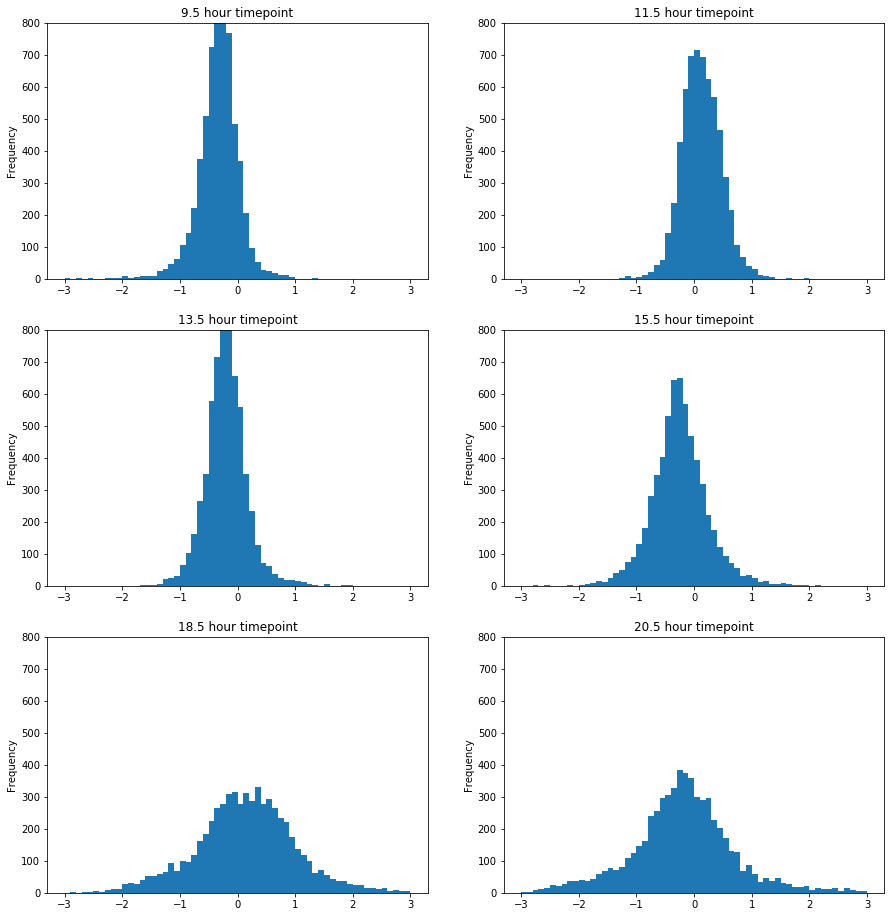

In [7]:
# The first line is a function definition, we'll name it "histograms"
# We'll also require that you pass in a data set to make histograms out of
def histograms(dataset):
    
    # Creating an empty figure on which we will plot things
    # the "figsize=(15, 16)" bit just set a custom size for the canvas to prevent squishing
    fig = plt.figure(figsize=(15, 16))
    
    # Now we're going to go through every timepoint *except* the first one and also number them
    for i, time in enumerate(timepoints[1:]):
    
        # add_subplot specifies a number of rows and columns that will be drawn,
        # it also needs to be told which subplot is currently being worked on, 
        # which is what the i+1 is for. The +1 is necessary since enumerate starts on 0.
        fig.add_subplot(3,2,i+1)
        
        # Pretty simple, get the time column from the dataset and plot a histogram
        # The histogram has 60 bins, and covers the range of -3 to 3
        dataset[time].plot.hist(bins=60, range = (-3, 3))
        
        # Title the image
        plt.title("{} hour timepoint".format(time))
        
        # Set a standard y-axis height for easier comparison
        plt.ylim([0,800])
        
# Now we'll call the function
histograms(dataset)

Of course, we can also visualize the distribution with a KDE plot, and the code is almost identical

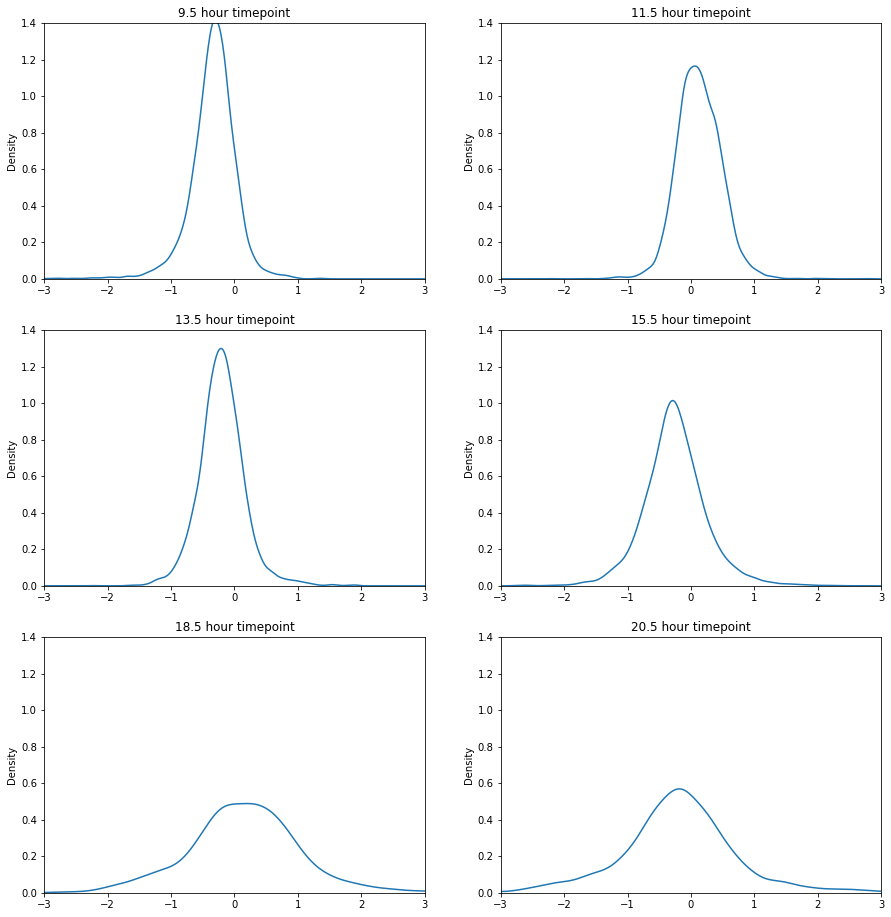

In [8]:
def kdes(dataset):

    fig = plt.figure(figsize=(15, 16))
    
    for i, time in enumerate(timepoints[1:]):
        fig.add_subplot(3,2,i+1)
        
        dataset[time].plot.kde()
        plt.title("{} hour timepoint".format(time))
        
        plt.ylim([0,1.4])
        plt.xlim([-3, 3])
        
        
kdes(dataset)

Even in the final timepoints **vast** majority of the genes never change expression very much. Since we're interested in the genes that are affected by starvation, let's remove all the points whose expression never changes by more than 40% (0.5 on our scale).

We'll start by getting every row where *all* the values along the row axis (that is, along axis 1) have an absolute value of less than 0.5.   
In Python that looks like:

In [9]:
duds = dataset[(dataset[timepoints].abs() < 0.5).all(axis=1)]
# Alternatively we could use "(dataset[timepoints].abs() > 0.5).any" in the middle there. 
duds.describe()

,0,9.5,11.5,13.5,15.5,18.5,20.5
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,-0.023672,-0.215698,0.092564,-0.149481,-0.149086,0.050245,-0.107836
std,0.163472,0.189740,0.205860,0.180489,0.215854,0.272557,0.242434
min,-0.486538,-0.499760,-0.499812,-0.499056,-0.498712,-0.494143,-0.499947
25%,-0.130129,-0.353815,-0.054641,-0.278146,-0.323819,-0.170038,-0.294133
50%,-0.022284,-0.241631,0.090328,-0.154879,-0.176726,0.059820,-0.145969
75%,0.088877,-0.114544,0.254383,-0.031825,-0.003758,0.295878,0.058659
max,0.450676,0.494666,0.498588,0.432919,0.489353,0.499965,0.498671


Wow, 867 genes that barely changed expression at all. Let's trim them and look at the new histograms.

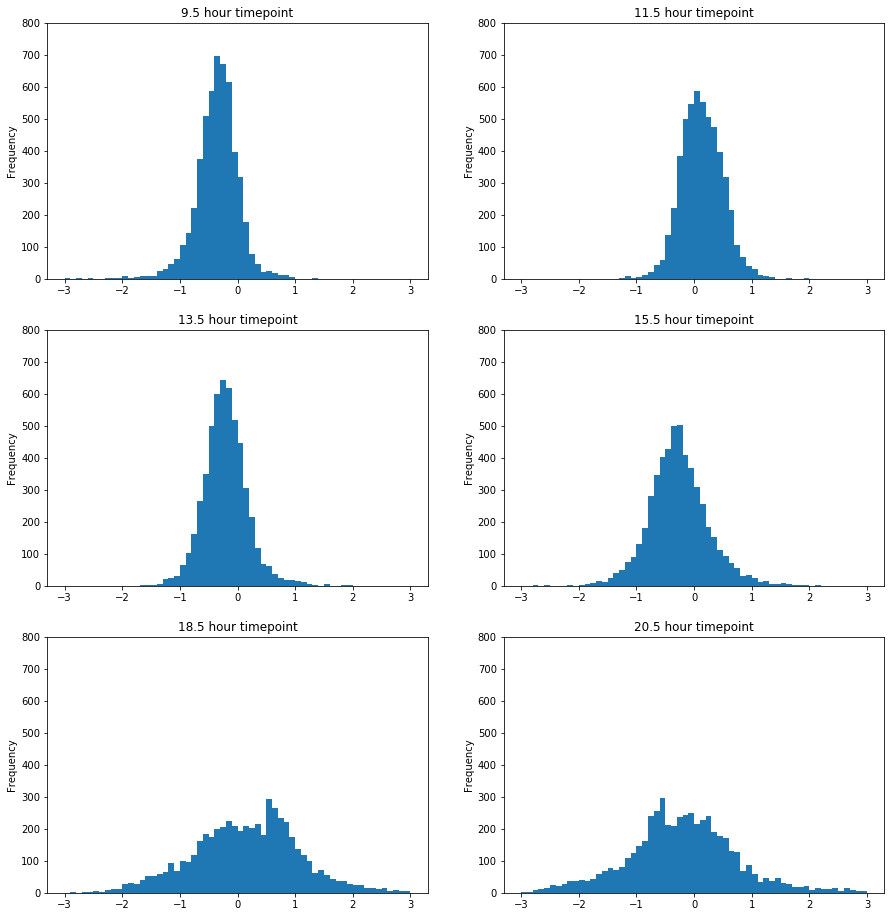

In [10]:
trimmed_data = dataset.drop(duds.index)
histograms(trimmed_data)

It seems like most of the changes happen in the last 5 hours. Interestingly, the middle parts of the last 2 histograms, while smaller, are *not* completely empty. Huh.

Maybe a different kind of graph would provide more insight. 

Since the data is made up of values and timepoints, it should be pretty easy to plot a line graph, but since pandas likes to plot with the "index" as the x axis, we're going to want to transpose the data, first.

Since plotting 4000+ lines on one graph would be a complete mess, we'll plot a sample of 20 points we obtained earlier.

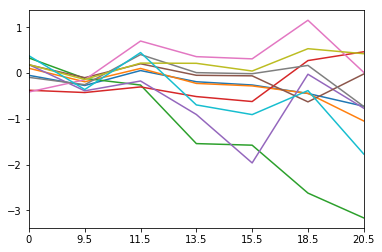

In [11]:
# First we grab a sample, just like we did earlier but now with 20 points
sample = trimmed_data.sample(10)

# Then we transpose it
transposed_sample = sample[timepoints].T

# And finally we plot. The semicolon prevents that annoying text string from appearing
transposed_sample.plot.line(legend=False);

Aha! It seems like many of the points jump around a lot, many of them spike early and then drop back to 0, which means either this kind of variation is totally normal of *any* gene, **or** there's something interesting going on.

If we wanted to focus on just the extreme genes we *could* drop more data points, but it's possible that some of these shifts are important parts of the yeast's biology, and if we drop too much data we risk oversimplifying.

That said, it would be nice to somehow categorize these patterns and get a list of proteins whose expression levels over time are similar.   
For that we can use:
## Unsupervised Machine Learning
Specifically, the K-means clustering algorithm, sometimes called "Lloyd's Algorithm", which is a fast and very popular tool for clustering data into categories. It's far from perfect, with algorithms like the "Expectation-Maximization clustering" algorithim tending to obtain better results with more room for subtlety, but it's extremely fast and can be used in most scenarios with little to no issue.

To see it in action, let's whip up some clusters:

In [12]:
# First we'll pick some points to use as the true centers of the clusters
xs, ys = [-9, -4, 9], [9, -6, 4]

# Then we'll pick some sigma values
sigmas = [4, 3, 4]

# And finally create some blank lists
xdata, ydata = [], []

# All that's left is to make a few clusters with a for loop
for i in range(3):
    # We'll get a bunch of x and y coordinates from a normal distribution
    coordsx = list(np.random.normal(xs[i], sigmas[i], (30)))
    coordsy = list(np.random.normal(ys[i], sigmas[i], (30)))
    
    # Saving them for later
    xdata += coordsx
    ydata += coordsy
    
# Finally, we're going to "zip" together the x and y coordinates into a bunch of x,y points
points = [(x, y) for x,y in zip(xdata, ydata)]

# And add those points to a new DataFrame
example = pandas.DataFrame(points, columns= ["x", "y"])
example.head()

,x,y
0,-7.851853,0.193370
1,-4.808001,3.351480
2,-3.392786,11.425495
3,-9.116417,9.013564
4,-8.763465,4.753542


Let's take a look at our points on a scatterplot!

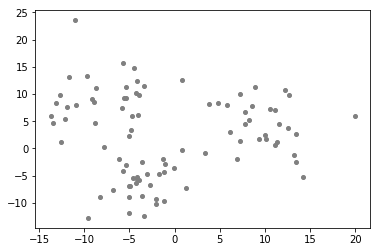

In [13]:
fig, ax = plt.subplots()
ax.plot(example["x"],example["y"], "o", color='grey',  markersize = 4);

Looking good! The next step is to decide how many clusters we want out algorithim to find, the "K" in "K-means".

I'm going to say 3, for what are hopefully obvious reasons.

In [14]:
k = 3

The K-means algorithm is fairly simple, it just has 3 steps. 

### Step1: Pick a random set of points to be used as the centers of the first clusters

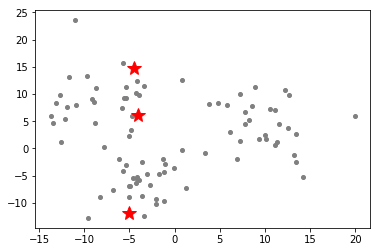

In [15]:
# Choosing 3 random rows from our example data
sample = example.sample(k)

# And getting the coordinates of those points out as a list
centerslist = sample[["x", "y"]].values

#Finally, we'll plot the centers as big red stars on the same axis as the rest of the points
ax.plot(centerslist.T[0],centerslist.T[1], '*', color = 'red', markersize = 15);
fig

### Step 2: do a "Points to Clusters" step
Every point is added to whatever cluster is closest, and we should make this a new function.

We should first define a function that tells us the distance between points, and one that determines what center is closest to a given point

In [16]:
# The distance between point 1 and point 2
def distance(p1, p2):
    # Is the cartesian distance between the points!
     return sqrt(sum([(x-i)**2 for x,i in zip(p1, p2)]))

# Point to Cluster takes a single point
def p2c(point):
    point = list(point)
    # Looks at the distance to all the centers
    distances = [distance(point, center) for center in centerslist]
    #And returns the index of the smallest distance
    return distances.index(min(distances))

Now we can apply this p2c function to every row in the frame

In [17]:
# To save some typing I will shorthand the columns I want to plot
cols = ["x", "y"]

example['Cluster'] = example[cols].apply(p2c, axis=1, raw=True)

# Let's see the numbers of points in each cluster
example.groupby("Cluster").count()

,x,y
Cluster,,
0,11,11
1,53,53
2,26,26


That's not great, each cluster should have exactly 40 points.
Let's see the graph at this stage:

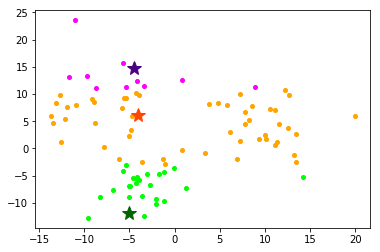

In [18]:
# First we'll need some distinct colors for the points and the chosen centers
colors = ['fuchsia', 'orange', 'lime']
centercolors = ['indigo', 'orangered', 'darkgreen']

# We may as well define a new function.
# The scatterplot function takes data and assumes "k" number of clusters
def scatterplot(data, k=k):
    
    # Creates a drawing space and axis
    fig, ax = plt.subplots()

    # Then  goes through a loop for each of k clusters
    for i in range(k):
    
        # getting the rows of the points for each cluster
        cluster = example[(example["Cluster"] == i)]

        # plotting the points
        ax.plot(cluster.x, cluster.y, "o", label="Cluster {}".format(i), color = colors[i], ms=4)

        # and adding the centers again
        ax.plot(centerslist.T[0][i],centerslist.T[1][i], '*', color = centercolors[i], markersize = 15);
    
    return fig, ax

# I'm only assigning fig and ax as variables because of some trickery I will employ later.
fig, ax = scatterplot(example);

Phew, this is messy, two of the randomly chosen centers are practically  the same! Let's hurry up and complete the algorithm.

### Step 3: do a "Clusters to Points" step
Move the center to the middle of the new cluster by finding the average of the entire cluster, and making that the new center point.

*Sidenote: if the dataset was extremely large we could save time here by using some kind of Monte Carlo method to take a statistical sample of points and finding their average, which can dramatically speed up an already fast algorithm*

In [19]:
# We input the dataframe of our points       
def c2p(data, columns):
    
    # Chuck out that old centerslist
    centerslist = []
    
    # Go through all k centers
    for i in range(k):
        
        # And add the mean of each coordinate in each column to the centerlist
        centerslist += [data[(data.Cluster == i)][columns].mean().tolist()]
    return np.array(centerslist)
centerslist = c2p(example, cols)

That's the function, defined and applied. Let's add these new centers as pentagons.

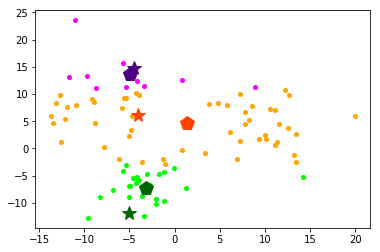

In [20]:
for i in range(k):
    ax.plot(centerslist.T[0][i],centerslist.T[1][i], 'p', color = centercolors[i], markersize = 15);
fig

Those centers look more appropriate. The green center has shifted upwards, and the orange center has moved right. Let's repeat steps 2 and 3 and then plot the graph again. 

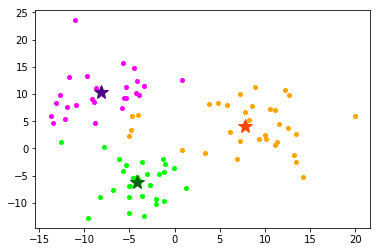

In [21]:
# First we apply the p2c algorithm to all the rows
example['Cluster'] = example[cols].apply(p2c, axis=1, raw=True)

# Then we get new centers
centerslist = c2p(example, cols)

# And finally, we plot the new graph
fig, ax = scatterplot(example);

It's certainly getting there! We can repeat that process again to get the centers closer to their true values.

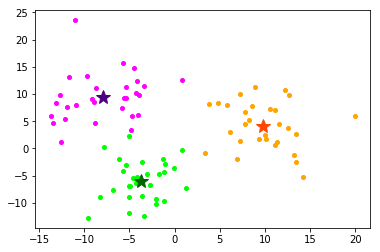

In [22]:
example['Cluster'] = example[cols].apply(p2c, axis=1, raw=True)
centerslist = c2p(example, cols)

for i in range(k):
    ax.plot(centerslist.T[0][i],centerslist.T[1][i], 'p', color = centercolors[i], markersize = 15);
scatterplot(example);

We can loop the algorithm 20 more times, and it will improve with each loop.

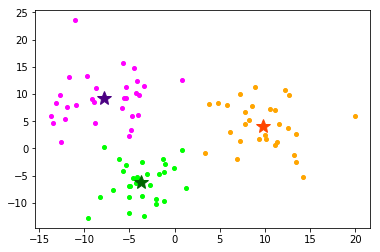

In [23]:
for i in range(20):
    example['Cluster'] = example[cols].apply(p2c, axis=1, raw=True)
    centerslist = c2p(example, cols)
    
scatterplot(example);

Looking good!
Feel free to change all the variables above and watch the process with different centers, numbers of clusters, standard deviations, etc.

Otherwise, 

## It's time to get back to our main dataset

We can choose any number of clusters we want, so let's choose something like 4 clusters for this data.
I also think that typing "trimmed_data" all the time is going to be annoying, so we're going to just call it "data".

In [24]:
k = 4
data = trimmed_data

We're also going to want a good list of colors to use. My favourite from the standard set available on matplotlib is "tab10":

In [25]:
colors = cm.tab10

We're ready to do the first 2 steps of the algorithm:

### Step1:
* Choose K rows, 
* get their coordinates into a list

In [26]:
sample = data.sample(k)
centerslist = sample[timepoints].values

### Step2:  
* Assign the rest of the points into clusters
* We may as well take a look at counts

In [27]:
data['Cluster'] = data[timepoints].apply(p2c, axis=1, raw=True)
data.groupby("Cluster").count()

,ORF,GENE_NAME,0,9.5,11.5,13.5,15.5,18.5,20.5
Cluster,,,,,,,,,
0,1385,790,1380,1377,1373,1381,1377,1383,1377
1,403,235,403,403,403,403,403,403,403
2,2278,1326,2278,2278,2278,2278,2278,2278,2278
3,1220,891,1220,1220,1220,1220,1220,1220,1220


So we've got our 5286 points arranged into 5 groups of various sizes.

Unfortunately, one of the [Curses of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is that we can't make those nice little 2D scatter plots when working with 3d Data.

Fortunately, we can plot a few line graphs. 

Since a single graph with over 5000 lines on it would be completely incomprehensible, let's only plot the arithmetic mean of each cluster's expression at each time, along with a transparent bar showing one standard deviation.

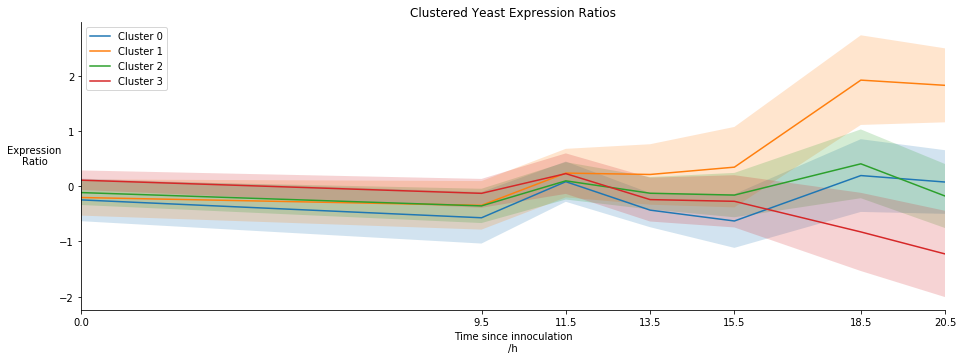

In [28]:
# I'm going to add a "clusters_to_plot" parameter with a default value of range k, which might be useful later.
def plotmeans(data, clusters_to_plot = range(k)):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 2, 1])
    # That list there simply stretches the x axis out, it will make the graph look nicer.
    
    # I'm also tired of graphs with black lines on the top and left, let's remove those.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # A nice title, and some axis labels
    plt.title("Clustered Yeast Expression Ratios")
    plt.xlabel("Time since innoculation\n/h")
    plt.ylabel("Expression\nRatio", rotation = 0, labelpad = 25)
    # the "\n" is code for "new line"
    
    # This takes the list of column names and turns them into numbers, 
    # so we can accurately plot time on the x axis
    xdata=[float(i) for i in timepoints]
    
    # We'll also go ahead and set the axis to display those ticks
    ax.set_xticks(xdata)
    ax.set_xlim(0, 20.5)

    # And finally, the meat
    # for every integer from 0 up to the number of clusters
    for i in clusters_to_plot:
        
        # Take just the datapoints whose cluters matches that integer        
        cluster = data[(data.Cluster == i)][timepoints]
        
        # Calculate a mean and a standard deviation
        mean = cluster.mean()
        std = cluster.std()
        
        # Plot the time value on the x axis, the mean expression on the y, give it a label, and give it a color
        ax.plot(xdata, mean, label="Cluster " + str(i), color= colors(i))
        
        # Then, for every timepoint fill the space in between one deviaion below and above, 
        # make it 80% transparent, and give it the same color
        plt.fill_between(xdata, mean-std, mean+std, alpha=0.2, facecolor = colors(i))
    
    # Lastly, slap a legend in the upper lft corner
    plt.legend(ncol=1, loc = 'upper left');
    return fig
plotmeans(data);

It seems like cluster 1 (orange) has already picked up a lot of the genes that increase in expression, but the other 4 clusters are all in a jumble, especially at the 15.5 and 18.5 hour timepoints.

It's somewhat messy, though. We'll try a completely different approach and plot lines for a sample of 200 rows from each column in separate subplots.

In [29]:
data.groupby("Cluster").ORF.count()

Cluster
0    1385
1     403
2    2278
3    1220
Name: ORF, dtype: int64

We can also try to plot a KDE curve of each of the clusters at each of the timepoints:

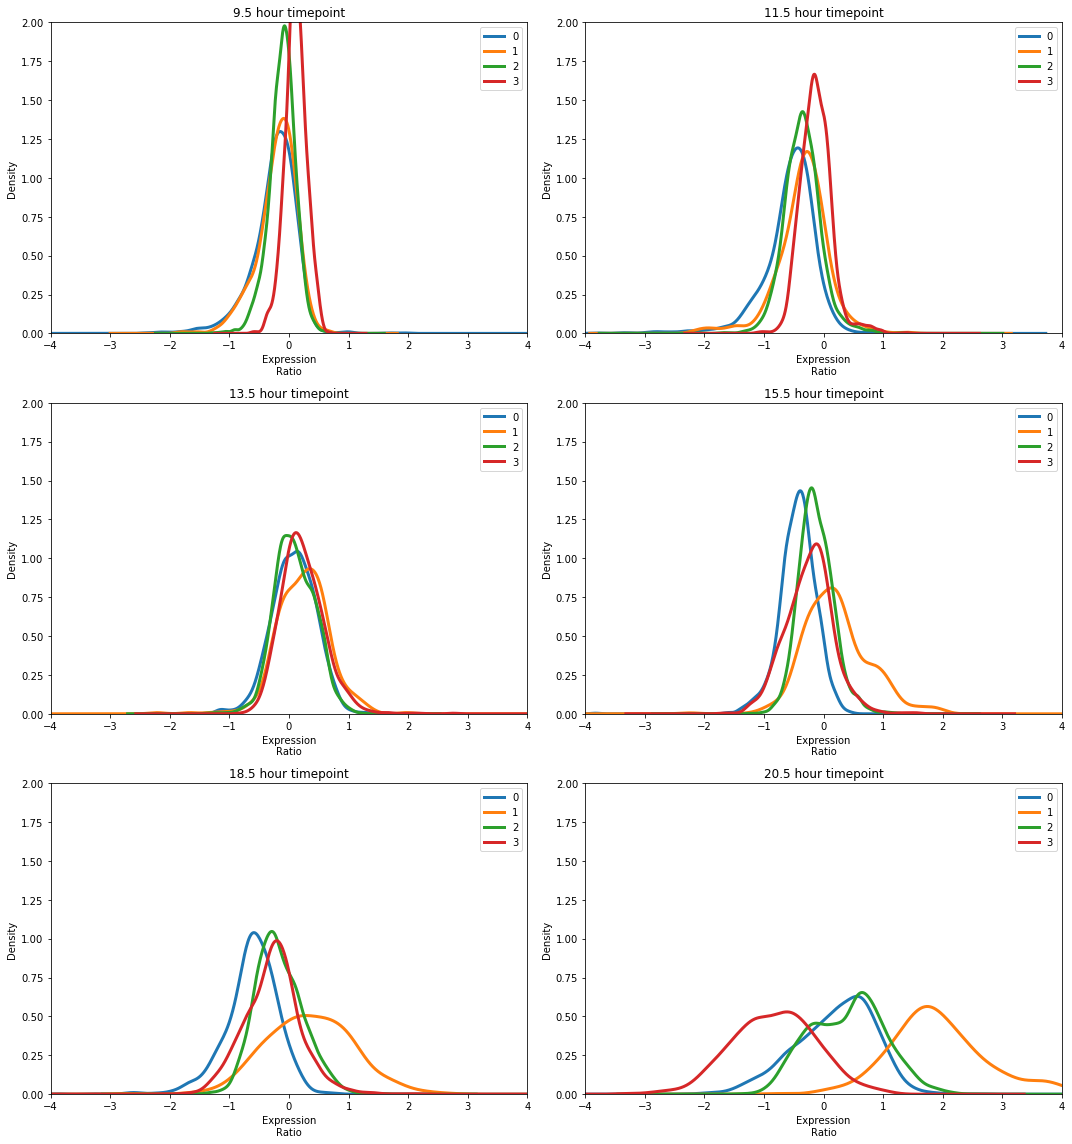

In [30]:
# One note is that "cluster_to_plot" variable being set to None by default. 
def manykde(data, timepoints, clusters_to_plot = None):
    fig = plt.figure(figsize=(15, 16))
    ax = []
    
    # Here we are going to see if the user put anything in for the "clusters_to_plot" parameter
    # And if they didn't, set it to range(k)
    if clusters_to_plot == None:
        clusters_to_plot = range(k)
    # We had to do it this way because making "range(k)" the default would have 
    # used the k-value from when the function was defined, and not from when the function was called.
    
    # Moving on,

    # For each timepoint get a number and the name of the timepoint
    for i, time in enumerate(timepoints[1:]):

        # Make a subplot in a 3-row, 2 column chart with the position being that number
        # Add the subplot to a list
        ax += [fig.add_subplot(3,2,i+1)]

        # And then for each cluster
        for j in clusters_to_plot:

            # Get the points where the cluster matches the one we want to plot
            s = data[data['Cluster'] == j][timepoints[i]]

            # Plot a KDE curve
            s.plot.kde(label=j, color=colors(j), ax=ax[i], linewidth = 3)

            # Title, axis label, limits, legend
            plt.title("{} hour timepoint".format(time))
            plt.xlabel("Expression\nRatio")
            plt.ylim([0,2])
            plt.xlim([-4, 4])
            plt.legend()

        # This handy-dandy little function automates the laying-out of the subgraphs, saving us the work
        fig.tight_layout()
    return fig, ax
manykde(data, timepoints);
    

And again, it looks like orange represents high-expression genes, and the rest are an overlapping jumble. One thing we didn't see earlier is that cluster 3, the red cluster, has a very narrow density at the begginning, timepoint. It also looks like clusters 0 and 2 are nigh-identical at each timepoint.

Time to run the algorithm a few times, maybe 20 cycles?

### Step 3+: Move the centers and repeat the process

In [31]:
for i in range(20):
    centerslist = c2p(data, timepoints)
    data['Cluster'] = data[timepoints].apply(p2c, axis=1, raw=True)

Let's try something completely different, instead of taking all of the 6400 rows and plotting them on graphs - which would take longer than I want to wait - we can take a sample of, say, 200 from each cluster and plot the clusters individually:

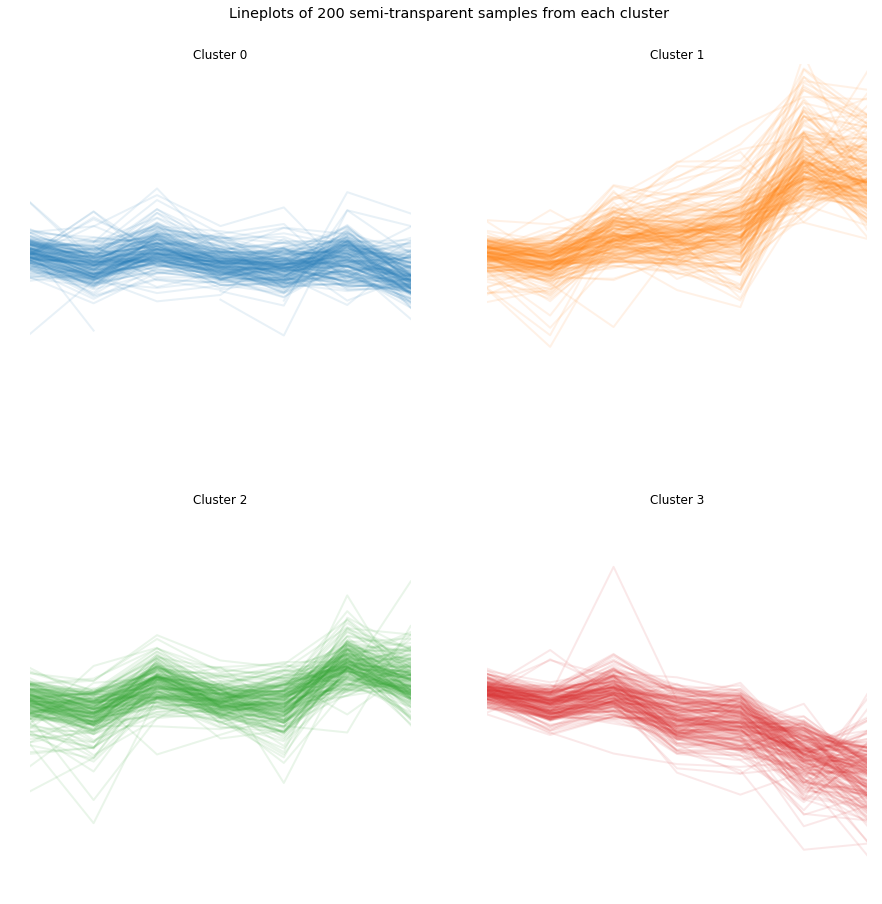

In [32]:
def manylines(data, samples = 200):
    fig = plt.figure(frameon=False, figsize=(15, 15))

    plt.title("Lineplots of {} semi-transparent samples from each cluster".format(samples), y=1.05, fontsize='x-large')
    plt.box('off')
    plt.axis('off')

    ax=[]
    for i in range(k):
        ax.append(fig.add_subplot(int(ceil(k/2)),2,i+1))

        ax[i].set_ylim([-4,4])
        ax[i].set_title("Cluster {}".format(i))
        plt.box('off')
        plt.axis('off')
        plt.setp(ax[i].get_xticklabels(), visible=False)

        cluster = data[(data.Cluster == i)][timepoints].sample(samples)
        cluster.loc[:, "0":"20.5"].T.plot(legend=None, color = [colors(i)], ax=ax[i], alpha = 0.1, linewidth=2)
        
manylines(data)

It's almost like an art piece! We can clearly see patterns in each cluster:


We can of course plot the KDEs and the means again:

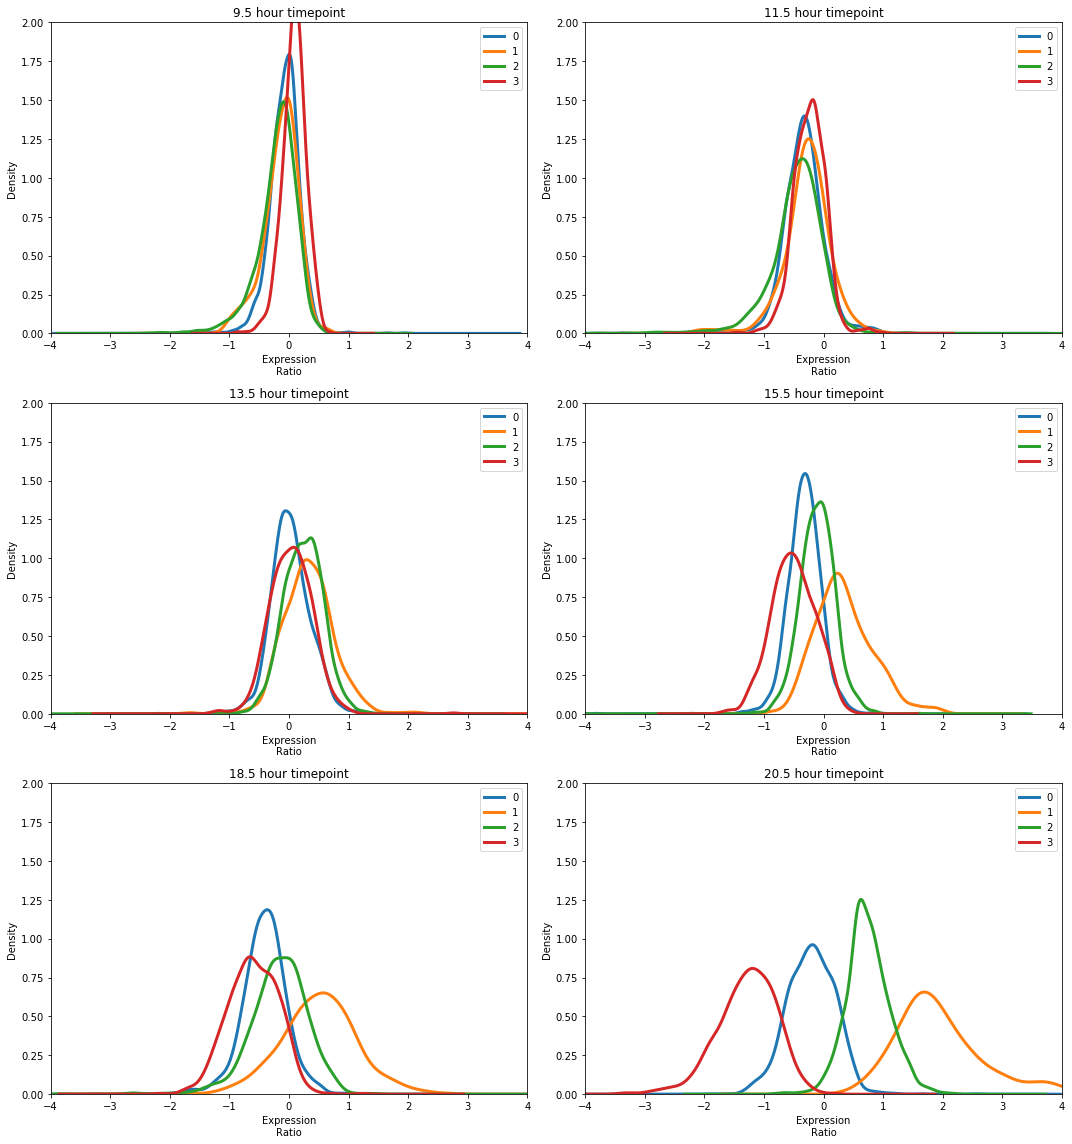

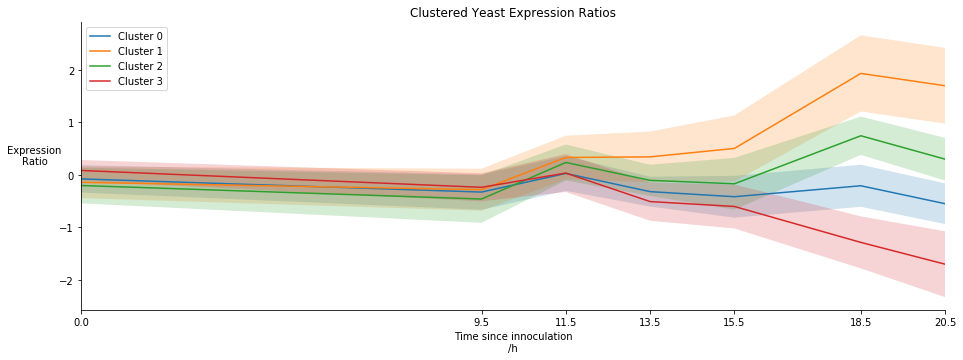

In [33]:
manykde(data, timepoints);
plotmeans(data);

Would you look at that, we've got some nice, clean separation!

It looks like cluster1 (orange) and cluster 3 (red) are the genes most affected by starvation.

Thanks to the clusters_to_plot parameter we built in, we can look at just those clusters.

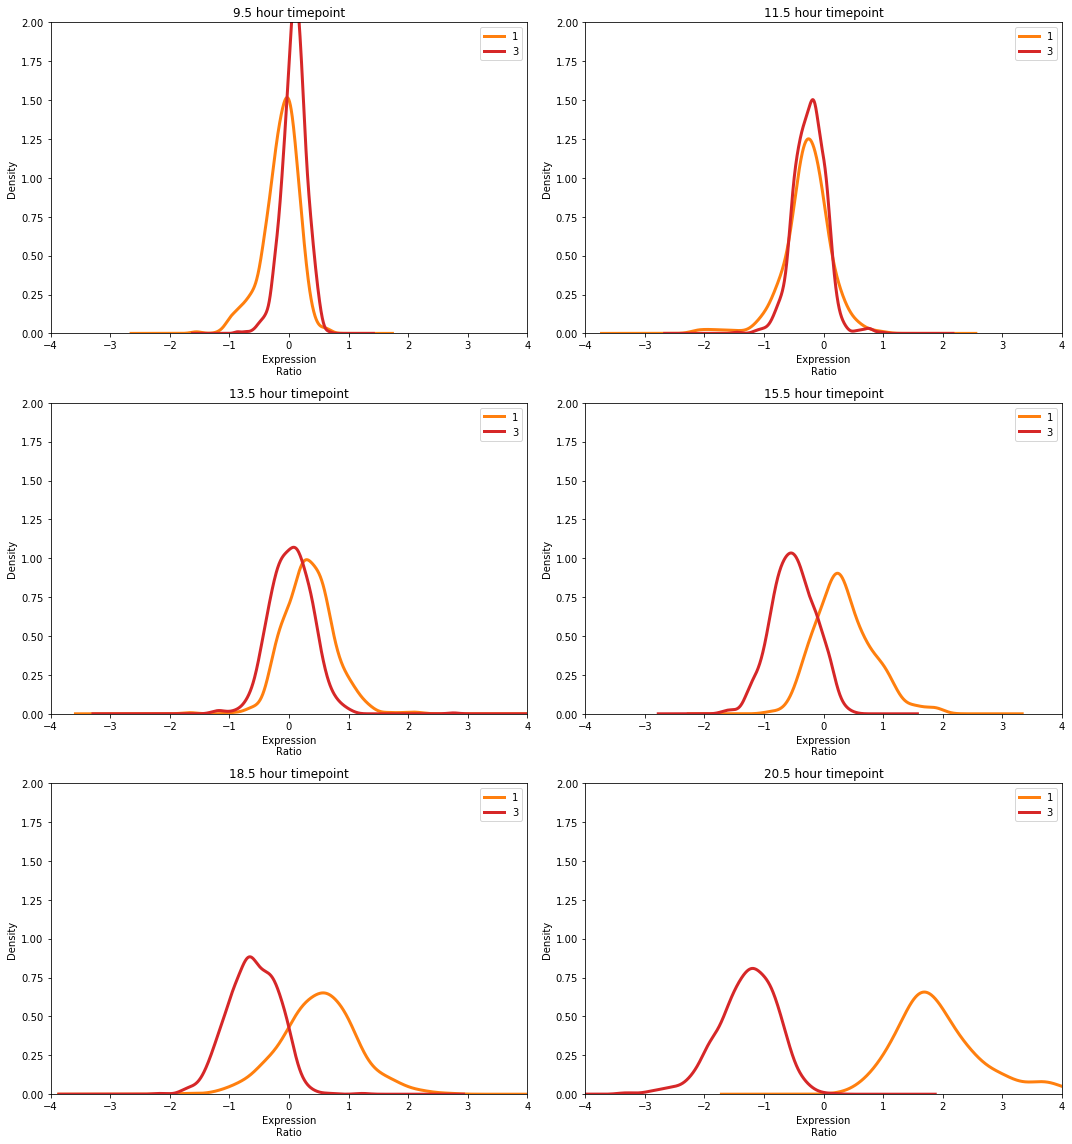

In [34]:
manykde(data, timepoints, clusters_to_plot = [1, 3]);

Let's not forget that we have the names of all of these genes, too: Let's look at a random sample of some of the genes from cluster 1, the highly expressed cluster.

In [35]:
data[data['Cluster'] == 1].sample(5)

,ORF,GENE_NAME,0,9.5,11.5,13.5,15.5,18.5,20.5,Cluster
2269,YIL125W,KGD1,0.225286,0.240522,0.387852,0.120892,0.594022,1.496288,3.025160,1
4933,YDR275W,NaN,-0.693535,-0.137504,0.529619,-0.235103,-0.338699,2.054408,1.017037,1
4960,YDR377W,ATP17,0.092173,-0.041111,0.354470,0.148843,0.791383,1.071641,1.207859,1
218,YDL124W,NaN,-0.030374,-0.542393,-0.076166,0.517663,0.617737,1.988153,0.686374,1
5966,YOR161C,NaN,-0.068302,-0.153801,0.504142,0.880805,0.784805,2.339697,1.313879,1


PNC1 is a cool name. What's that?

We can look it up on [yeastgenome.org](https://www.yeastgenome.org/locus/S000003005) and it tells us that PNC1

> converts nicotinamide to nicotinic acid; part of the NAD(+) salvage pathway; required for life span extension by calorie restriction

Hey, there we go! A protein that get expressed when yeast is starving.

[Transition]

## Advanced Plotting: Animation

Let's take the full dataset and make a movie out of the clustering process!

We can use then full-sized dataset, and find 6 clusters inside of it.

Set K, get sample, make centers, assign clusters

In [36]:
k = 6

sample = data.sample(k)
centerslist = sample[timepoints].values
data['Cluster'] = data[timepoints].apply(p2c, axis=1, raw=True)

We're going to use matplotlib's "Func Animation" module and we're going to animate the movement of the KDE lines for the final timepoint.

This is going to be a lot of code, but to be honest most of it is formatting.

In [37]:
# This part is nothing new
def clustering_animation(frames, interval = 250):
    
    # We're going to declare a few variables
    labels = ["Cluster {}".format(i) for i in range(k)]
    x = data.groupby("Cluster").size()    
    xdata = [float(t) for t in timepoints]
    
    # And then make the master figure and remove the box and axis
    fig = plt.figure(figsize=(10, 15))
    plt.box('off')
    plt.axis('off')
    
    # The title here is long, so we're splitting it onto 2 lines. Python will treat everything
    # that's inside of the same bracket as being on the same line.
    # y = 1.05 moves the title up to 105% of it's normal height. This will give us room for a legend.
    plt.title("Animation of K-means Clustering on a 7-dimensional Microarray Dataset",
              y=1.05, fontsize='x-large')  
    
    # For the first graph we'll do the means of the clusters
    # We'll create an axis
    ax1 = fig.add_subplot(3,1,1)
    
    # Remove those pesky spines and set the limits
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim([-3,3])

    # Add some titles and lables
    ax1.set_title("Mean Values of Yeast Expression Ratios")
    ax1.set_xlabel("Time since innoculation\n  /h")
    ax1.set_ylabel("Expression\nRatio", rotation = 0, labelpad = 25)
    
    # And now we are going to render the lines and add those lines to a list
    # We're doing this so we can directly change the line data later, without having to redraw everything
    lines = []
    for i in range(k):
        cluster = data[(data.Cluster == i)][timepoints]
        mean = cluster.mean()
        
        #lobj means "line object", the trailing comma is really important here for reasons we won't get into
        lobj, = ax1.plot(xdata, mean, color = colors(i), label=labels[i], lw=4)
        # adding the line object to the list
        lines.append(lobj)
    
    # The eagle-eyed among you will notice that we didn't draw the standard deviations yet.
    # That's because the "fill_between" is not easy to change on-the-fly, so we're going to redraw it every frame
    # instead of just editing the data like we do for the lines
    
    
    # The second plot will be the KDEs
    # Once again we're not bothering to render a first set of lines, they're too much effort to edit on-the-fly
    # So this is all formatting.
    ax2 = fig.add_subplot(3,1,2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim([0,2])
    ax2.set_xlim([-4, 4])
    ax2.set_title("KDE Plot of Expression Ratios at the 20.5 hour Timepoint")
    ax2.set_xlabel("Expression\nRatio")

    #The third plot will be a bar graph of the number of datapoints in each cluster
    ax3 = fig.add_subplot(3,1,3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_title("Number of Points in Each Cluster")
    ax3.set_ylabel("Number", rotation = 0, labelpad = 30)
    ax3.set_xlabel("Cluster")
    
    # Here we create a bunch of rectangles which we will add to a list to update later.
    rectangles = list(bar([i for i in range(k)], data.groupby("Cluster").size(), 
                          color = [colors(i) for i in range(k)]))
    
    
    # One final bit of formatting to create and fiddle with a legend some of this stuff is complex
    leg = fig.legend(lines,                       # We'll use the list of lines as our representative image 
                     [i for i in range(k)],       # And title the lines as according to thier cluster number
                     title = 'Cluster:',          # The legend will have its own title
                     fontsize='large',            # We may as well make large text
                     ncol=k,                      # The legend has k columns (one row)
                     loc = 'center',              # The legend will be positioned based on its center
                     bbox_to_anchor=(0.57, 0.96), # Here we fiddle with moving the legend around
                     frameon = False)             # Finally we're removeing the box around the legend
    
    # Here we do a little more fiddling with the legend's title
    leg._legend_box.align = "left"                # Left align the title text
    leg.get_title().set_position((-55, -19))      # Move the text down to be beside the row of entries
    leg.get_title().set_fontsize('large')         # And make the fontsize consistent with the entries
    
    # Finally we do that tight_layout thing, with an extra request for more "height padding" between subplots
    plt.tight_layout(h_pad=3)
    
    
    #The next piece is the code for updating each frame. "i" is just the framecount, we won't need it though.
    def animate(i):
        # We have to tell python that "centerslist" should be the list we declared outside of the function,
        # Otherwise it will be confused when we update the variable later
        global centerslist
    
        # We're going to update the rectangles first, because they are easy
        # n is the number of datapoints in each cluster
        n = data.groupby("Cluster").size().values
        
        # we pair up rectangles and n-values, and then assign the rectangle heights to the n-value
        for rectangle, n in zip(rectangles, n):
            rectangle.set_height(n)

        # These two lines delete the existing standard deviation fills and the KDE plot lines
        ax1.collections = []
        ax2.lines = []
        
        # Now we draw the line graph and KDE plot
        # I'm being a bit sneaky here an piggybacking the kde-updates onto the same loop as the line-update
        for j, line in enumerate(lines):
            # Grab the mean, standard deviation for the cluster
            cluster = data[(data.Cluster == j)][timepoints]
            mean = cluster.mean()
            std = cluster.std()
            
            # Then simply set the line data to the new data
            line.set_data(xdata, mean)
            
            # And draw that fill-between
            ax1.fill_between(xdata, mean-std, mean+std, facecolor = colors(j), alpha=0.1)
            
            # For the KDE plot we are going to get only the last timepoint
            # In python asking a list for a negative index counts from the tail-end
            s = cluster[timepoints[-1]]
            
            # Finally we plot the KDE curve for this loop
            s.plot.kde(label=labels[j], color=colors(j), ax = ax2, linewidth = 3)
            
        # All that's left is to step through the clustering algorithim once
        centerslist = c2p(data, timepoints)
        data['Cluster'] = data[timepoints].apply(p2c, axis=1, raw=True)
        
        # And to return the updated rectangles and lines   
        return rectangles + lines
    
    
    # It's time to use the "FuncAnimation" function to build our movie
    anim = animation.FuncAnimation(fig,               # "fig" is the fig we just built
                                   animate,           # Animate is the function that updates the data
                                   frames=frames,     # Frames is however many frames we put in the function call above
                                   interval=interval, # Interval is the time to wait between frames (in milliseconds)
                                   blit=True);        # blit will save a bit of time by only drawing things that change
   
    plt.close() # This closes down the figure
    return anim # and then we return the finished animation!


Phew! That was a LOT of text.

Before you get freaked out, remember that most of it was comments, and then most of the actual code was formatting.

Anyways, it's time to wind and watch a movie!

*Note: If you are running this at home it may take a minute or so to render, if you get an error saying you have no moviewriter, your FFMPEG install is not set up correctly*

*Note2

In [38]:
clustering_animation(60)

It looks at a glance like creating more clusters hasn't accomplished anything special, but let's take a look at that art-piece plot

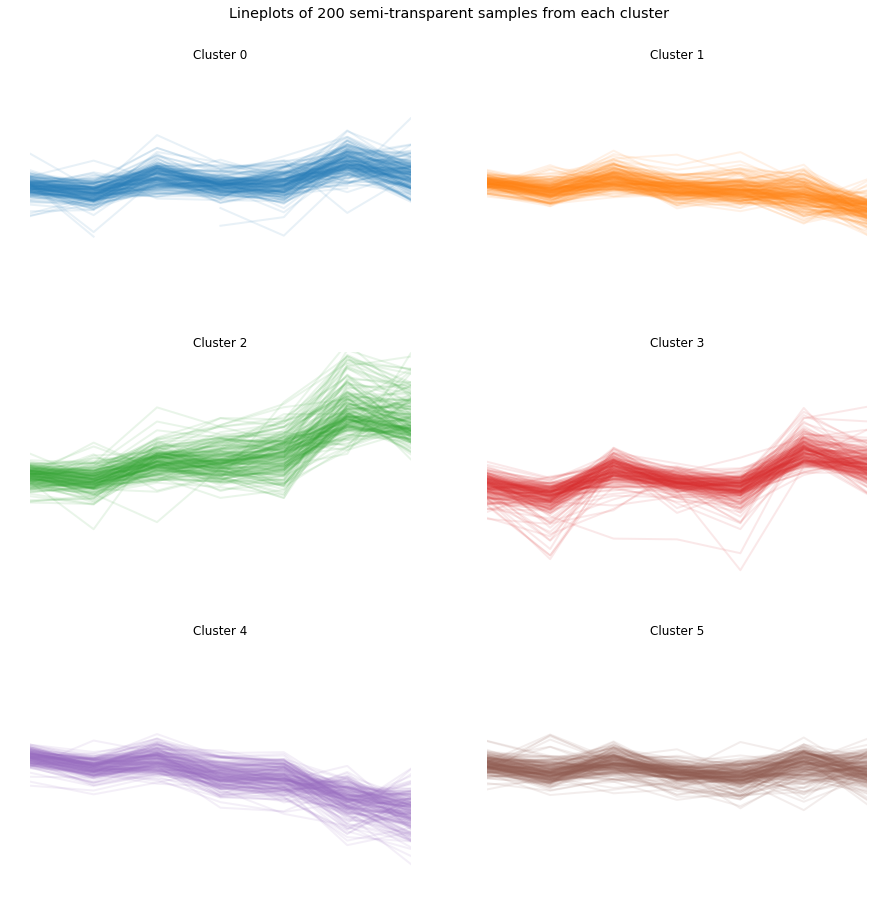

In [39]:
manylines(data)

Despite the muddling of clusters 0, 1, 3, and 5 in the KDE plot, there are clear patterns to be seen in each cluster:
* Cluster 0 slowly increases
* Cluster 1 slowly decreases
* Cluster 2 rapidly increases, and it's a lot more dispersed
* Cluster 3 is all over the place
* Cluster 4 sharply decreases
* Cluster 5 is tame and barely moves at all.

And that's it (for now), but if you're using this notebook on your own computer feel free to explore some of the genes in each cluster, maybe see why some seem to vary a lot while others don't by looking up different genes from each cluster in the yeast genome database.

Also: It was slightly annoying to have to decide on a K-value to sort with every time, wasn't it? Clustering algorithims like K-means are often called "Flat", as opposed to the "Hierarchical" clustering algorithims that create tiered trees such as this one:
![Hierarchy](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/CAH_tea_after_ACM01.png/603px-CAH_tea_after_ACM01.png)

Where the data comes out as a tree, and you can look at each level of clustering.

Those tend to take much, much longer to run, though, and people avoid them if they think that simply guessing a K-value would work about as well.